# <span style="color:green">__Data Science Bootcamp__

## <span style="color:black">__Project__: Machine Learning Project

---
### <span style="color:navy">__Context__

<span style="color:dark_grey">

## Kickstarter Project Success

Analyse and model success factors of kickstarter campaigns. Give new projects an idea what is needed for a successful funding and potentially even predict campaign success upfront.
In recent years, the range of funding options for projects created by individuals and small companies has expanded considerably. In addition to savings, bank loans, friends & family funding and other traditional options, crowdfunding has become a popular and readily available alternative.

Kickstarter, founded in 2009, is one particularly well-known and popular crowdfunding platform. It has an all-or-nothing funding model, whereby a project is only funded if it meets its goal amount; otherwise no money is given by backers to a project.
A huge variety of factors contribute to the success or failure of a project — in general, and also on Kickstarter. Some of these are able to be quantified or categorized, which allows for the construction of a model to attempt to predict whether a project will succeed or not. The aim of this project is to construct such a model and also to analyse Kickstarter project data more generally, in order to help potential project creators assess whether or not Kickstarter is a good funding option for them, and what their chances of success are.

**Source:** Kickstarter Project Success Data, containing information about their campaigns.

**Final Deliverables:**
1. Slide deck PDF pushed to GitHub designed for non-technical stakeholders that outline findings, recommendations, and future work (10 min presentation).
2. Jupyter notebook following PEP8 designed for data science/technical audience.
3. (Recommended) Python script for generating (takes .csv as argument and saves the model locally) and running your model from the terminal (takes test.csv and model as arguments and outputs accuracy and predictions as .csv) (you can still use the template repo : https://github.com/neuefische/ds-ml-project-template)

**Technical:**
* hh


---
### <span style="color:navy">__Importing Packages and Data__


In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime, timezone
import json

# Libraries for data import
import os
import glob

# Preprocessing
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import plot_confusion_matrix, recall_score, accuracy_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.metrics import fbeta_score, make_scorer


# Define a plotting style to be used for all plots in this notebook
plt.style.use('tableau-colorblind10')

In [3]:
# Kickstarter data

path = "data/data-2"
all_files = glob.glob(os.path.join(path + "/*.csv"))
li = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
data = pd.concat(li, axis=0, ignore_index=True)

df = data.copy()

In [4]:
# data.to_csv('data/csv_files_combined.csv',index=False)

In [5]:
#df = pd.read_csv('data/csv_files_combined.csv')

In [6]:
# Formatting the columns
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 200)

# pd.set_option('display.max_colwidth', None)


---
### <span style="color:navy">__Exploratory Data Analysis__

In [7]:
#Print the shape of the data

print('Kickstarter dataset')
print('==================')
print('# observations: {}'.format(df.shape[0]))
print('# features:     {}'.format(df.shape[1]-1))

Kickstarter dataset
# observations: 209222
# features:     36


In [8]:
#df.head(5)

In [9]:
#df.category[0]

In [10]:
#df.shape

In [11]:
#df.columns

In [12]:
#df.info()

In [13]:
#df.describe()

> Relevant columns in JSON format were separated, their features were concatenated to the main data frame and some irrelevant columns were dropped.

json plan:
* first explode json columns category and location
* select columns that we want to keep from json dataframes categroy and location
* concat selected columns to original dataframe
* delete all columns we dont want (including original json columns)

In [14]:
# define function to explode json columns

def explode_json(df, col_name):
    ''' explodes json columns'''
    exploded = pd.json_normalize(df[col_name].apply(json.loads))
    return exploded

In [15]:
# explode and concatenate JSON columns location and category

# explode 'location', first replace nan rows with 'empty_json'
empty_json = '{"id":"nan","name":"nan","slug":"nan","short_name":"nan","displayable_name":"nan","localized_name":"nan","country":"nan","state":"nan","type":"nan","is_root":"nan","urls":{"web":{"discover":"nan","location":"nan"},"api":{"nearby_projects":"nan"}}}'
df['location'] = df['location'].fillna(empty_json)
df_location_exploded = explode_json(df, 'location')

# select location columns to keep
df_location_exploded_keep = df_location_exploded[['country', 'state','localized_name','type']]
df_location_exploded_keep.columns = df_location_exploded_keep.columns.str.replace('state', 'loc_state')
df_location_exploded_keep.columns = df_location_exploded_keep.columns.str.replace('country', 'loc_country')
df_location_exploded_keep.columns = df_location_exploded_keep.columns.str.replace('localized_name', 'city')


# explode category, then split slug column by "/"
df_category_exploded = explode_json(df, 'category')
df_category_exploded[['slug_1','slug_2']] = df_category_exploded['slug'].str.split('\/',expand=True)

# select category columns to keep
df_category_exploded_keep = df_category_exploded[['name','position','slug_1','slug_2']]

df_category_exploded_keep.columns = df_category_exploded_keep.columns.str.replace('name', 'name_cat')



In [16]:
# concatenate exploded JSON columns

df = pd.concat([df,df_location_exploded_keep,df_category_exploded_keep], axis=1)

In [17]:
#df.columns

In [18]:
df.head(5)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,current_currency,deadline,disable_communication,friends,fx_rate,goal,id,is_backing,is_starrable,is_starred,launched_at,location,name,permissions,photo,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,loc_country,loc_state,city,type,name_cat,position,slug_1,slug_2
0,315,Babalus Shoes,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,$,True,USD,1552539775,False,NaN,1.000000,28000.0,2108505034,NaN,False,NaN,1548223375,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",Babalus Children's Shoes,NaN,"{""key"":""assets/023/667/205/a565fde5382d6b53276...",28645.0,"{""id"":3508024,""project_id"":3508024,""state"":""in...",babalus-childrens-shoes,https://www.kickstarter.com/discover/categorie...,False,False,live,1548223375,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",28645.000000,international,US,CA,Novato,Town,Footwear,5,fashion,footwear
1,47,A colorful Dia de los Muertos themed oracle de...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,$,True,USD,1504976459,False,NaN,1.000000,1000.0,928751314,NaN,False,NaN,1502384459,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",The Ofrenda Oracle Deck,NaN,"{""key"":""assets/017/766/989/dd9f18c773a8546d996...",1950.0,"{""id"":3094785,""project_id"":3094785,""state"":""ac...",the-ofrenda-oracle-deck,https://www.kickstarter.com/discover/categorie...,True,False,successful,1504976459,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",1950.000000,domestic,US,TX,Euless,Town,Playing Cards,4,games,playing cards
2,271,"Electra's long awaited, eclectic Debut Pop/Roc...","{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,$,True,USD,1371013395,False,NaN,1.000000,15000.0,928014092,NaN,False,NaN,1368421395,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...","Record Electra's Debut Album (Pop, Rock, Class...",NaN,"{""key"":""assets/011/433/681/489fd66f7861fefd8c8...",22404.0,"{""id"":359847,""project_id"":359847,""state"":""inac...",record-electras-debut-album-pop-rock-classical,https://www.kickstarter.com/discover/categorie...,True,False,successful,1371013395,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",22404.000000,international,US,CA,Hollywood,Suburb,Rock,17,music,rock
3,3,The Mist of Tribunal is a turn-based card game...,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,£,False,USD,1489425776,False,NaN,1.308394,10000.0,596091328,NaN,False,NaN,1484245376,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",The Mist of Tribunal - A Card Game,NaN,"{""key"":""assets/015/091/198/216fbf1bdc3739e7971...",136.0,"{""id"":2825329,""project_id"":2825329,""state"":""in...",the-mist-of-tribunal-a-card-game,https://www.kickstarter.com/discover/categorie...,False,False,failed,1489425776,1.216066,"{""web"":{""project"":""https://www.kickstarter.com...",165.384934,domestic,LT,Kaunas County,Kaunas,Town,Playing Cards,4,games,playing cards
4,3,"Livng with a brain impairment, what its like t...","{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,$,True,USD,1357763527,False,NaN,1.000000,2800.0,998516049,NaN,False,NaN,1355171527,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",Help change the face of Brain Impairment,NaN,"{""key"":""assets/011/457/844/37ba63d35fefaba76e9...",2820.0,"{""id"":417385,""project_id"":417385,""state"":""inac...",help-change-the-face-of-brain

In [19]:
# dropJSON and unwanted columns
# originally: df = df.drop(['blurb', 'category', 'creator', 'currency', 'currency_symbol', 'currency_trailing_code', 'fx_rate', 'id', 'location', 'name', 'photo', 'profile', 'source_url', 'urls'], axis=1)

# drop json columns
df = df.drop(['category', 'creator','location','photo','profile'], axis=1)

# drop unwanted information
df = df.drop(['currency_symbol', 'currency_trailing_code', 'source_url', 'urls'], axis=1)


In [20]:
#df.columns = df.columns.str.replace('category_1', 'category')

In [21]:
df.columns

Index(['backers_count', 'blurb', 'converted_pledged_amount', 'country',
       'created_at', 'currency', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'name',
       'permissions', 'pledged', 'slug', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'usd_type',
       'loc_country', 'loc_state', 'city', 'type', 'name_cat', 'position',
       'slug_1', 'slug_2'],
      dtype='object')

# create combined columns

### columns to keep from [L. Lewis](https://github.com/L-Lewis/Kickstarter-success-machine-learning/blob/master/Kickstarter-project.ipynb)
* backers_count                  
* category                       
* country                        
* created_at                     
* deadline                       
* id                             
* is_starrable                   
* launched_at                    
* staff_pick                     
* state                          
* usd_pledged                    
* blurb_length                   
* sub_category                   
* usd_goal                       
* name_length                    
* creation_to_launch_days        
* campaign_days                  
* launch_day                     
* deadline_day                   
* launch_month                   
* deadline_month                 
* launch_time                    
* deadline_time                  
* pledge_per_backer          

### dates:

* created_at
* deadline
* launched_at
* launch_day
* launch_time
* launch_month
* deadline_day
* deadline_month
* deadline_time
* creation_to_launch_days
* campaign_days

In [22]:
df['created_at'] = df.created_at.apply(datetime.fromtimestamp)


In [23]:
# creating datetime formatted deadline deadline_time, deadline_month, deadline_day

df['deadline'] = df.deadline.apply(datetime.fromtimestamp)

df["deadline_month"] = df["deadline"].dt.strftime("%M")
df["deadline_day"] = df["deadline"].dt.strftime("%d")
df["deadline_time"] = df["deadline"].dt.strftime("%H") # hour of creation/launch/deadline



In [24]:
# creating launch_day, launch_time,launch_month

df['launched_at'] = df.launched_at.apply(datetime.fromtimestamp)

df["launch_month"] = df["launched_at"].dt.strftime("%M")
df["launch_day"] = df["launched_at"].dt.strftime("%d")
df["launch_time"] = df["launched_at"].dt.strftime("%H") # hour of creation/launch/deadline



In [25]:
# creating creation_to_launch_days, campaign_days

df['creation_to_launch_days'] = df['launched_at'].dt.day - df['created_at'].dt.day
df['campaign_days'] = df['launched_at'].dt.day - df['deadline'].dt.day


### combined value columns
                 
* blurb_length                   
* sub_category = slug_2
* category = slug_1
* usd_goal        
* name_length   
* pledge_per_backer          

In [26]:
# category and sub_category from slug_1 and slug_2
df.columns = df.columns.str.replace('slug_2', 'sub_category')
df.columns = df.columns.str.replace('slug_1', 'category')

In [27]:
# usd_pledged
df['usd_pledged'] = round(df['pledged'] * df['static_usd_rate'],2)


In [28]:
# usd_goal

# ! copy paste from l. Lewis !

# Calculate new column 'usd_goal' as goal * static_usd_rate
df['usd_goal'] = round(df['goal'] * df['static_usd_rate'],2)

# Dropping goal and static_usd_rate
df.drop(['goal', 'static_usd_rate'], axis=1, inplace=True)

In [29]:
# blurb_length

# Count length of each blurb
df['blurb_length'] = df['blurb'].str.split().str.len()
df['blurb_length'].replace({np.nan : 0}, regex=True,inplace=True)
df['blurb_length'] = df['blurb_length'].astype(int)

# Drop blurb variable
df.drop('blurb', axis=1, inplace=True)

In [30]:
# name_length

# Count length of each name
df['name_length'] = df['name'].str.split().str.len()
df['name_length'].replace({np.nan : 0}, regex=True,inplace=True)
df['name_length'] = df['name_length'].astype(int)

# drop original name column
df.drop(['name'], axis=1, inplace=True)

In [31]:
# pledge_per_backer
df['pledge_per_backer'] = round(df['usd_pledged']/df['backers_count'],2)


In [42]:
# percent pledged

df['percent_pledged'] = round(df['usd_pledged']/df['usd_goal']*100,2)


In [43]:
lewis_cols = ['backers_count',
'category',
'country',           
'created_at',             
'deadline',               
'id',                 
'is_starrable',                   
'launched_at',               
'staff_pick',                
'state',                 
'usd_pledged',                  
'blurb_length',
'sub_category',   
'usd_goal',    
'name_length',     
'creation_to_launch_days',      
'campaign_days',       
'launch_day',        
'deadline_day',         
'launch_month',          
'deadline_month',           
'launch_time',            
'deadline_time',             
'pledge_per_backer',
'percent_pledged'             
]

In [44]:
df_lewis = df[lewis_cols]


In [46]:
df = df_lewis.copy()

# back to Karine
---
### Data Cleaning and Adjustments

**STEP 1** -> Data frame was checked to identify possible duplicated rows in the data frame and it showed that there were no duplicates to be cleaned.

In [47]:
# Identify duplicates
df.duplicated().value_counts() # no duplicates

False    182560
True      26662
dtype: int64

**STEP 2** -> A missing entries analysis using the package "missingno" was necessary before further corrections could be done. Below the missing entries were identified by column to be further handled.

In [48]:
# Identify missing values
df.isna().sum()

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   0
sub_category                9041
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
percent_pledged                0
dtype: int64

<AxesSubplot:>

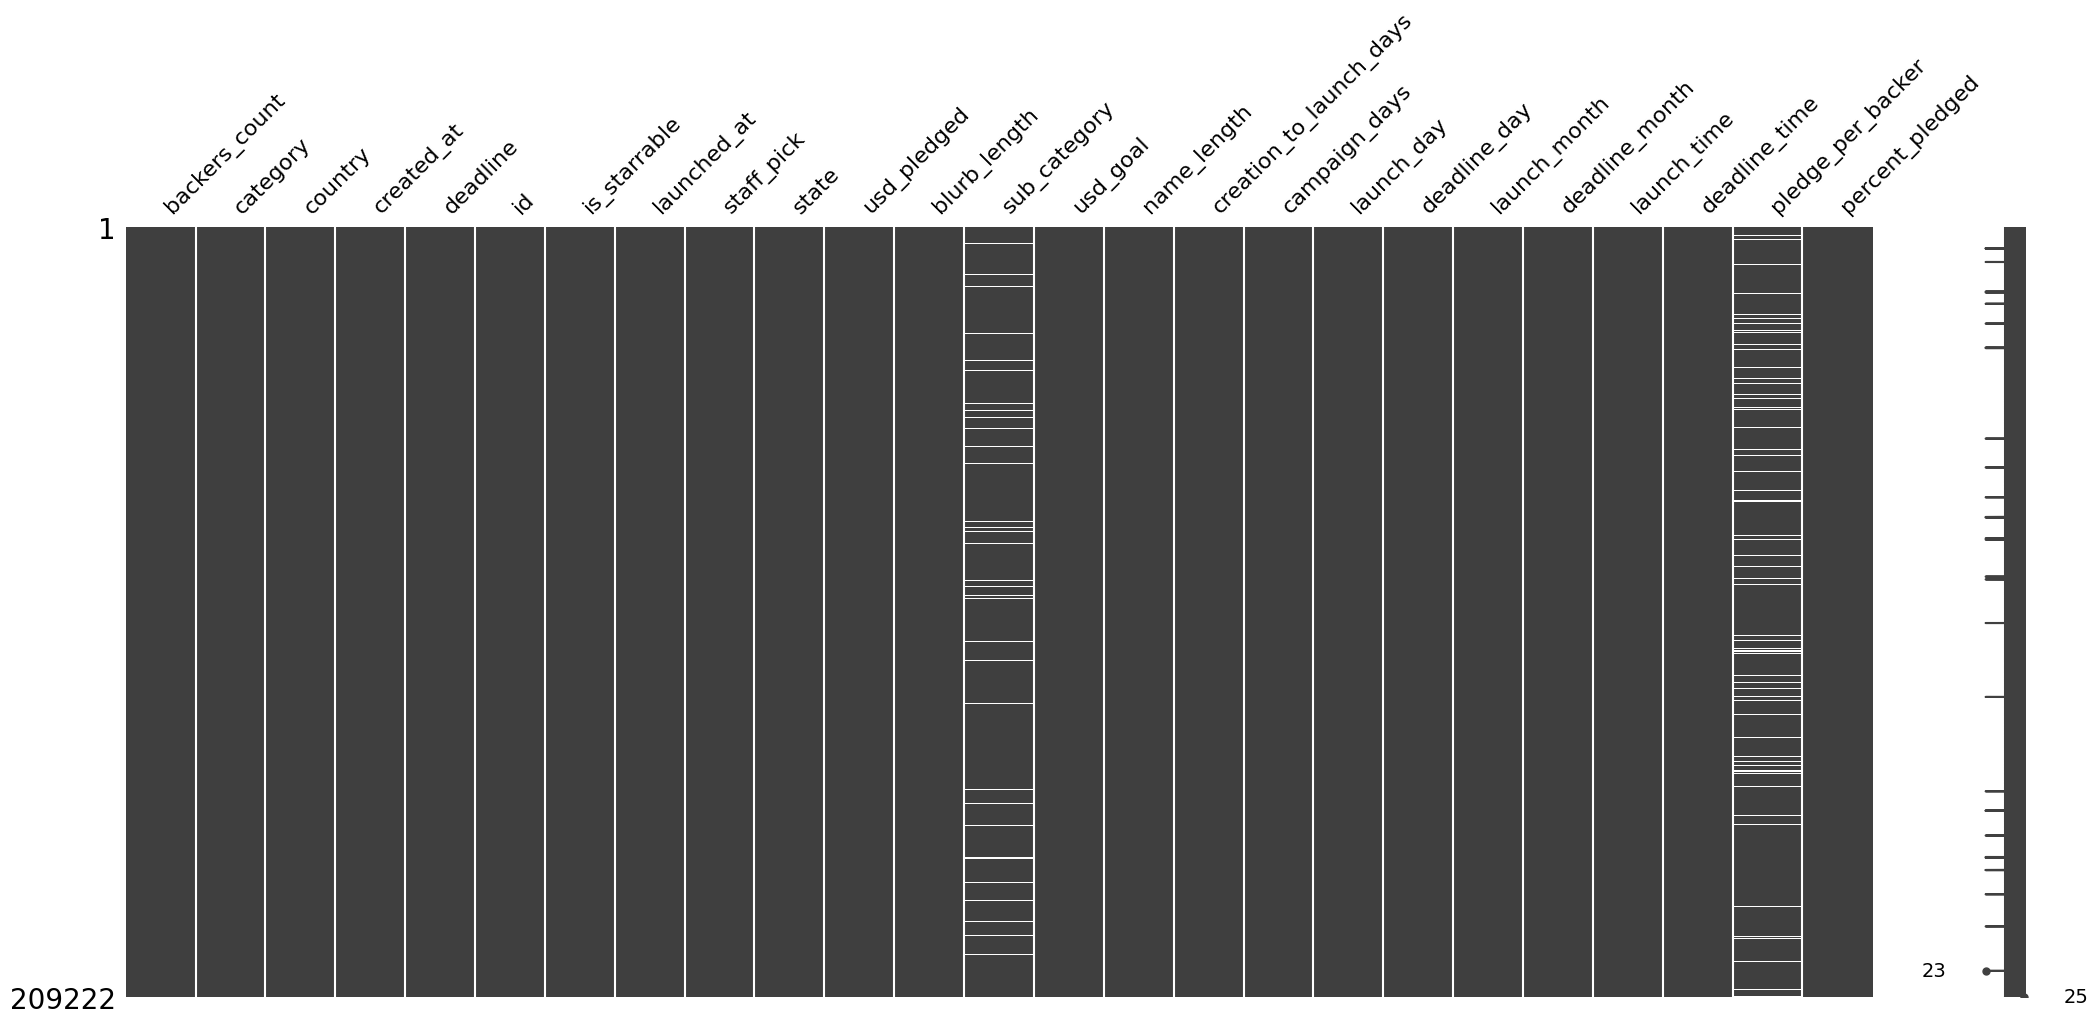

In [49]:
msno.matrix(df)

Blank columns were deleted as below:

In [138]:
#df = df.drop(['friends', 'is_backing', 'is_starred', 'permissions'], axis=1)

In [63]:
# pledge_per_backer missing values
print(df.isna().sum())
print('usd_pledged is 0:',df.usd_pledged[df['usd_pledged']== 0].count())

backers_count                  0
category                       0
country                        0
created_at                     0
deadline                       0
id                             0
is_starrable                   0
launched_at                    0
staff_pick                     0
state                          0
usd_pledged                    0
blurb_length                   0
sub_category                9041
usd_goal                       0
name_length                    0
creation_to_launch_days        0
campaign_days                  0
launch_day                     0
deadline_day                   0
launch_month                   0
deadline_month                 0
launch_time                    0
deadline_time                  0
pledge_per_backer          18362
percent_pledged                0
dtype: int64
usd_pledged is 0: 18362


In [80]:
df[df['usd_pledged'] == 0].groupby("state").usd_pledged.count()

state
canceled      3097
failed       15009
live             3
suspended      253
Name: usd_pledged, dtype: int64

In [82]:
# replace missing pledge_per_backer with zeros
df['pledge_per_backer'] = df['pledge_per_backer'].fillna(0)

In [85]:
# did inputting 0 work?
df.pledge_per_backer[df['pledge_per_backer'] == 0].count() 

18362

In [83]:
df.head(2)

,backers_count,category,country,created_at,deadline,id,is_starrable,launched_at,staff_pick,state,usd_pledged,blurb_length,sub_category,usd_goal,name_length,creation_to_launch_days,campaign_days,launch_day,deadline_day,launch_month,deadline_month,launch_time,deadline_time,pledge_per_backer,percent_pledged
0,315,fashion,US,2018-11-06 00:06:45,2019-03-14 06:02:55,2108505034,False,2019-01-23 07:02:55,False,live,28645.0,2,footwear,28000.0,3,17,9,23,14,02,02,07,06,90.94,102.3
1,47,games,US,2017-08-02 16:28:13,2017-09-09 19:00:59,928751314,False,2017-08-10 19:00:59,False,successful,1950.0,22,playing cards,1000.0,4,8,1,10,09,00,00,19,19,41.49,195.0


<AxesSubplot:>

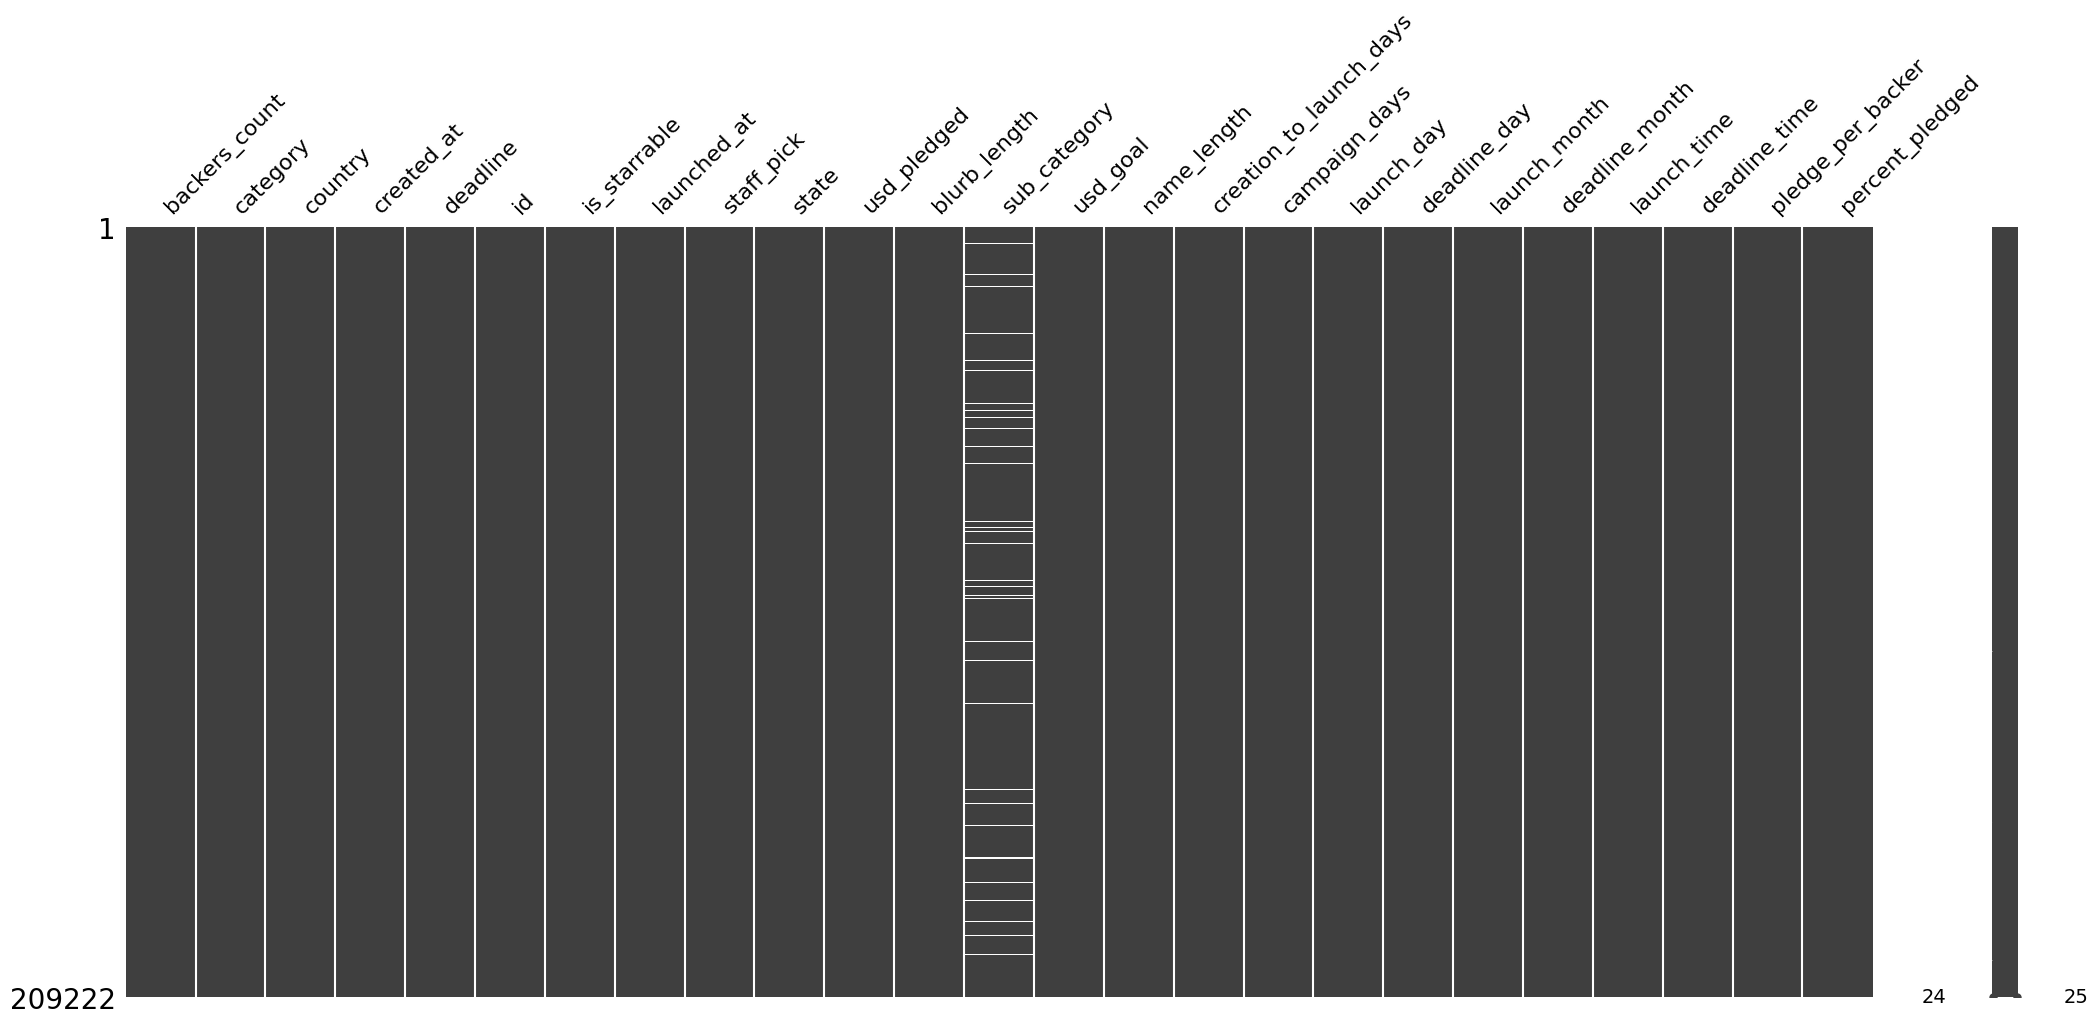

In [86]:
msno.matrix(df)

In [87]:
df.isna().sum()

backers_count                 0
category                      0
country                       0
created_at                    0
deadline                      0
id                            0
is_starrable                  0
launched_at                   0
staff_pick                    0
state                         0
usd_pledged                   0
blurb_length                  0
sub_category               9041
usd_goal                      0
name_length                   0
creation_to_launch_days       0
campaign_days                 0
launch_day                    0
deadline_day                  0
launch_month                  0
deadline_month                0
launch_time                   0
deadline_time                 0
pledge_per_backer             0
percent_pledged               0
dtype: int64

In [88]:
df['sub_category'] = df['sub_category'].fillna('unspecified')
df.isna().sum()

backers_count              0
category                   0
country                    0
created_at                 0
deadline                   0
id                         0
is_starrable               0
launched_at                0
staff_pick                 0
state                      0
usd_pledged                0
blurb_length               0
sub_category               0
usd_goal                   0
name_length                0
creation_to_launch_days    0
campaign_days              0
launch_day                 0
deadline_day               0
launch_month               0
deadline_month             0
launch_time                0
deadline_time              0
pledge_per_backer          0
percent_pledged            0
dtype: int64

**STEP 3** -> The data types were then checked and some inconsistencies were identified to be corrected.

In [89]:
df.dtypes

backers_count                       int64
category                           object
country                            object
created_at                 datetime64[ns]
deadline                   datetime64[ns]
id                                  int64
is_starrable                         bool
launched_at                datetime64[ns]
staff_pick                           bool
state                              object
usd_pledged                       float64
blurb_length                        int64
sub_category                       object
usd_goal                          float64
name_length                         int64
creation_to_launch_days             int64
campaign_days                       int64
launch_day                         object
deadline_day                       object
launch_month                       object
deadline_month                     object
launch_time                        object
deadline_time                      object
pledge_per_backer                 

> Dates were corrected to datetime:

**STEP 4** -> Understanding the dataset:

In [154]:
df['category'].value_counts()

film & video    27678
music           27378
technology      21165
art             20647
publishing      20245
food            16248
games           14035
fashion         12074
design           8889
comics           8805
photography      8119
crafts           7211
theater          6868
journalism       5817
dance            4043
Name: category, dtype: int64

In [156]:
df['state'].value_counts()

successful    117465
failed         75199
canceled        8624
live            7311
suspended        623
Name: state, dtype: int64

In [90]:
df.drop(df[df['state']== 'live'].index, inplace = True)
df.drop(df[df['state']== 'canceled'].index, inplace = True)
df.drop(df[df['state']== 'suspended'].index, inplace = True)

In [91]:
df['state'].value_counts()

successful    117465
failed         75199
Name: state, dtype: int64

**STEP 5** -> Saved new csv file after the dataframe was cleaned and adjusted:

In [160]:
df.to_csv('data/df_cleaned_for_ML.csv',index=False)

In [92]:
df.dtypes

backers_count                       int64
category                           object
country                            object
created_at                 datetime64[ns]
deadline                   datetime64[ns]
id                                  int64
is_starrable                         bool
launched_at                datetime64[ns]
staff_pick                           bool
state                              object
usd_pledged                       float64
blurb_length                        int64
sub_category                       object
usd_goal                          float64
name_length                         int64
creation_to_launch_days             int64
campaign_days                       int64
launch_day                         object
deadline_day                       object
launch_month                       object
deadline_month                     object
launch_time                        object
deadline_time                      object
pledge_per_backer                 

# Plotting / Key statistics

In [94]:
print("Key stats:\n")
#print("\nThe total amount of money that projects have aimed to raise is ${0:,.0f}".format(df.usd_goal.sum()))
print("The total amount of money pledged by backers is ${0:,.0f}".format(df.usd_pledged.sum()))
print("The total amount of money pledged by backers to successful projects is ${0:,.0f}".format(sum(df.loc[df['state'] == 'successful'].usd_pledged)))

print("\nThe total number of successful or failed projects launched on Kickstarter is: {0:,}".format(len(df)))
print("The total number of projects which were successfully funded is: {0:,}".format(len(df.loc[df['state'] == 'successful'])))
print(f"The proportion of completed projects which were successfully funded is: {int(round((len(df.loc[df['state'] == 'successful'])/len(df))*100,0))}%")

#print("\nThe mean project fundraising goal is ${0:,.0f}".format(df.usd_goal.mean()))
print("The mean amount pledged per project is ${0:,.0f}".format(df.usd_pledged.mean()))
print("The mean amount pledged per successful project is ${0:,.0f}".format(df.loc[df['state'] == 'successful'].usd_pledged.mean()))
print("The mean amount pledged per failed project is ${0:,.0f}".format(df.loc[df['state'] == 'failed'].usd_pledged.mean()))
      
print("\nThe mean number of backers per project is", int(round(df.backers_count.mean(),0)))
#print("The mean pledge per backer is ${0:,.0f}".format(df.pledge_per_backer.mean()))
#print("The mean number of days a campaign is run for is", int(round(df.campaign_days.mean(),0)))

Key stats:

The total amount of money pledged by backers is $2,604,185,859
The total amount of money pledged by backers to successful projects is $2,522,416,846

The total number of successful or failed projects launched on Kickstarter is: 192,664
The total number of projects which were successfully funded is: 117,465
The proportion of completed projects which were successfully funded is: 61%
The mean amount pledged per project is $13,517
The mean amount pledged per successful project is $21,474
The mean amount pledged per failed project is $1,087

The mean number of backers per project is 153


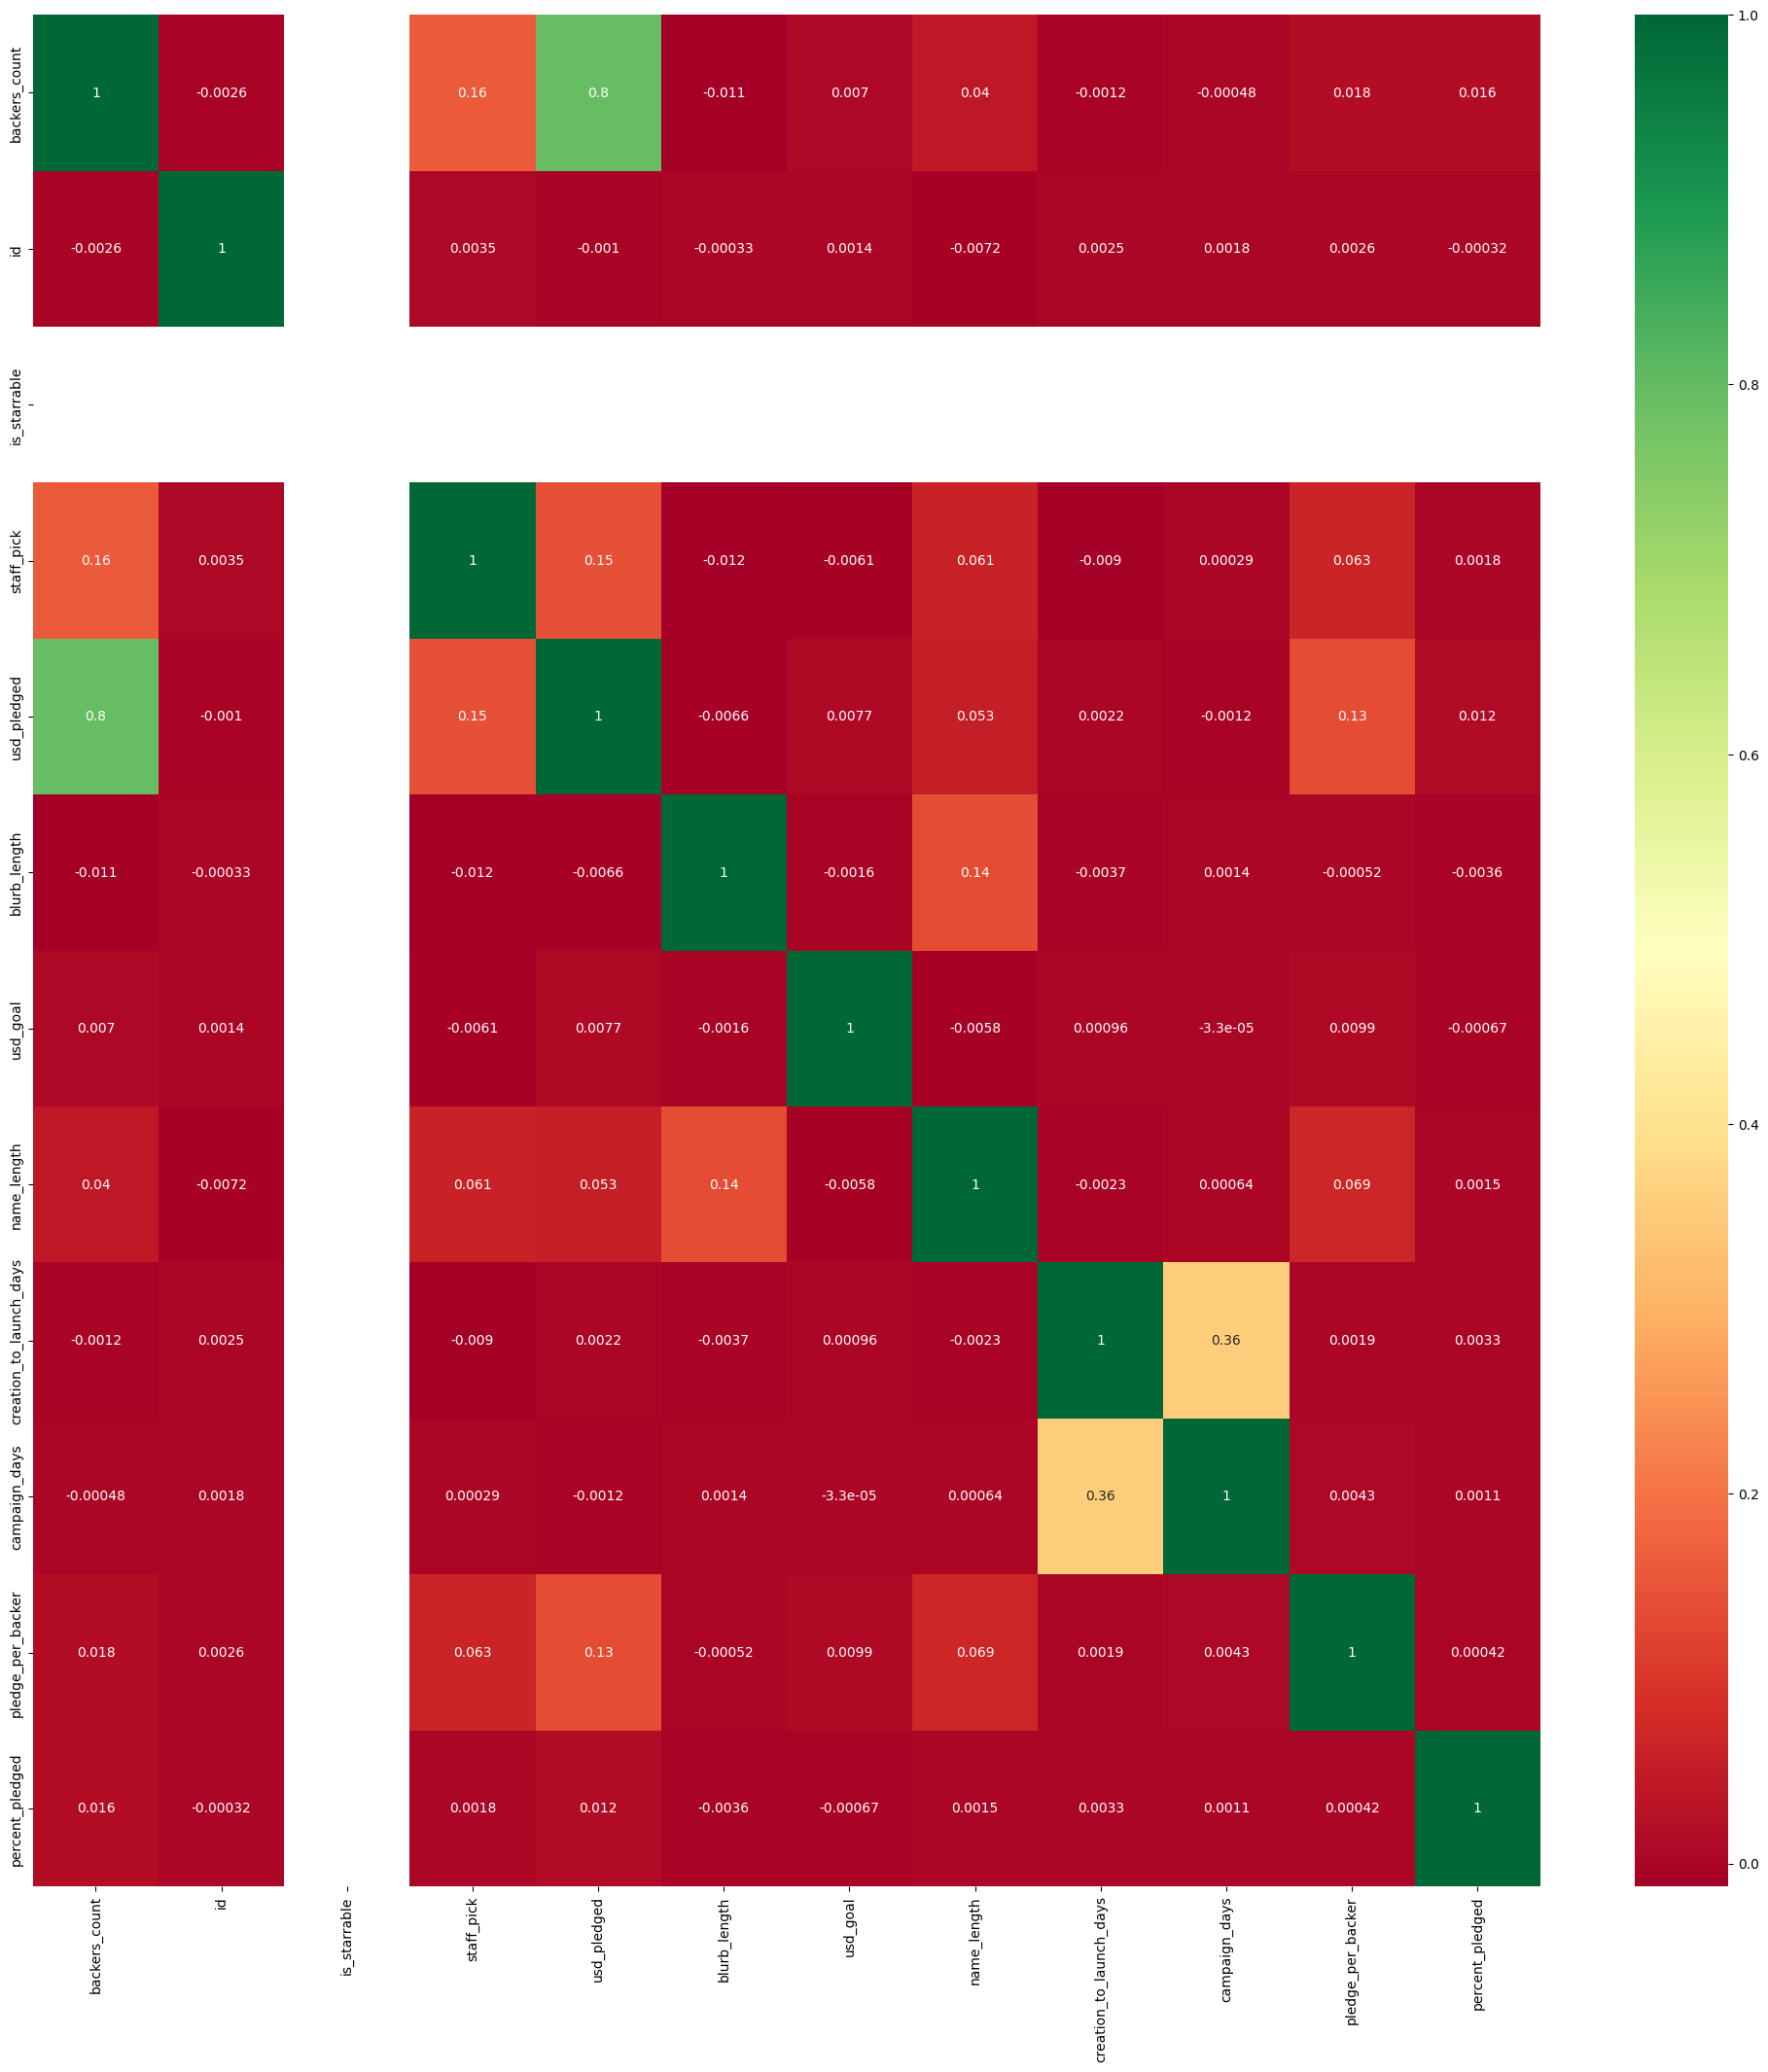

In [96]:
# https://github.com/hm6650/Kickstarter-Project/blob/main/Supervised_Machine_Learning.ipynb
import seaborn as sns
import matplotlib.pyplot as plt

corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(25,25))
#plot heat map

g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")


---
### How do succesful and failed projects differ?

The graphs below show how various features differ between failed and successful projects.

* Unsurprisingly, successful projects tend to have smaller (and therefore more realistic) goals - the median amount sought by successful projects is about half that of failed projects.
* The differences in the median amount pledged per project are more surprising. The median amount pledged per successful project is considerably higher than the median amount requested, suggesting that projects that meet their goal tend to go on to gain even more funding, and become 'over-funded'.
* On a related note, the difference between failed and successful companies is much larger in terms of amount pledged and the number of backers, compared to goal amount. Probably once potential backers see that a project looks like it will be successful, they are much more likely to jump on the bandwagon and fund it.
* Successful projects have slightly shorter durations.
* Successful projects tend to take slightly longer to launch, measured from the time the project was first created on the site.
* Average name and blurb lengths are very similar between failed and successful projects.
* Roughly 20% of successful projects were highlighted on the site as staff picks. It does not seem unreasonable to suggest a causative relationship here, i.e. that projects that are chosen as staff picks are much more likely to go on to be successful, and that only a few staff picks go on to fail. This measurement is possibly polluted by the point at which a project is chosen as a staff pick, however - e.g. a project may already have some backers and funding when it is chosen as a staff pick.

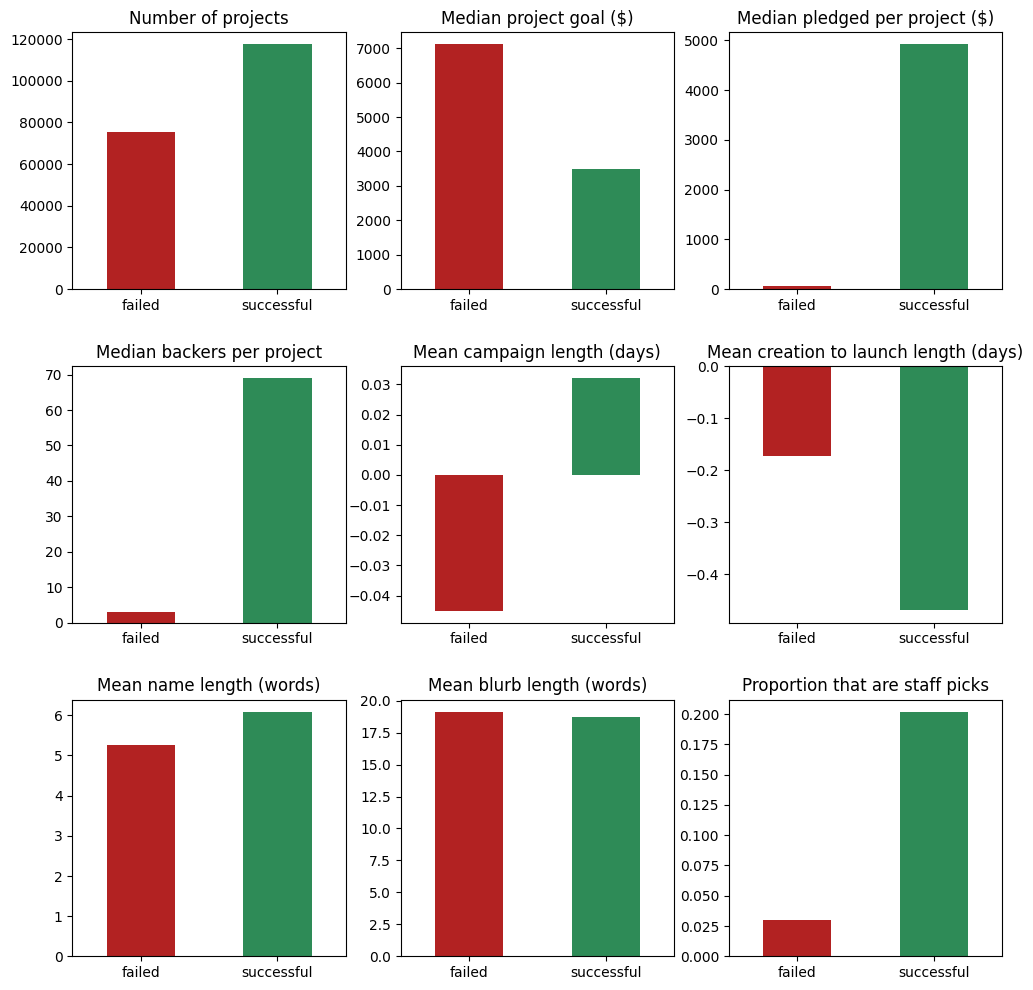

In [98]:
# Plotting the average amount pledged to successful and unsuccesful projects
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3, figsize=(12,12))

df['state'].value_counts(ascending=True).plot(kind='bar', ax=ax1, color=['firebrick', 'seagreen'], rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('state').usd_goal.median().plot(kind='bar', ax=ax2, color=['firebrick', 'seagreen'], rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('state').usd_pledged.median().plot(kind='bar', ax=ax3, color=['firebrick', 'seagreen'], rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

df.groupby('state').backers_count.median().plot(kind='bar', ax=ax4, color=['firebrick', 'seagreen'], rot=0)
ax4.set_title('Median backers per project')
ax4.set_xlabel('')

df.groupby('state').campaign_days.mean().plot(kind='bar', ax=ax5, color=['firebrick', 'seagreen'], rot=0)
ax5.set_title('Mean campaign length (days)')
ax5.set_xlabel('')

df.groupby('state').creation_to_launch_days.mean().plot(kind='bar', ax=ax6, color=['firebrick', 'seagreen'], rot=0)
ax6.set_title('Mean creation to launch length (days)')
ax6.set_xlabel('')

df.groupby('state').name_length.mean().plot(kind='bar', ax=ax7, color=['firebrick', 'seagreen'], rot=0)
ax7.set_title('Mean name length (words)')
ax7.set_xlabel('')

df.groupby('state').blurb_length.mean().plot(kind='bar', ax=ax8, color=['firebrick', 'seagreen'], rot=0)
ax8.set_title('Mean blurb length (words)')
ax8.set_xlabel('')

# Creating a dataframe grouped by staff_pick with columns for failed and successful
pick_df = pd.get_dummies(df.set_index('staff_pick').state).groupby('staff_pick').sum()
# Normalizes counts by column, and selects the 'True' category (iloc[1])
(pick_df.div(pick_df.sum(axis=0), axis=1)).iloc[1].plot(kind='bar', ax=ax9, color=['firebrick', 'seagreen'], rot=0) 
ax9.set_title('Proportion that are staff picks')
ax9.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

---
### How has fundraising changed over time?

The graph below shows the number of projects launched each month on Kickstarter from 2009 to 2019.

* The number of projects steadily grows from when the company was founded in 2009 up to the start of 2014.
* From 2012 Kickstarter started expanding into other countries, having launched initially in the US.
* Growth increased dramatically in 2014, and has remained at a high level since then, with a small decrease from 2015 to 2016.
* Seasonality is also hinted at, with fewer projects appearing to be launched in November.
* The second graph shows a similar story, with the cumulative amount pledged increasing more quickly from 2012 onwards.

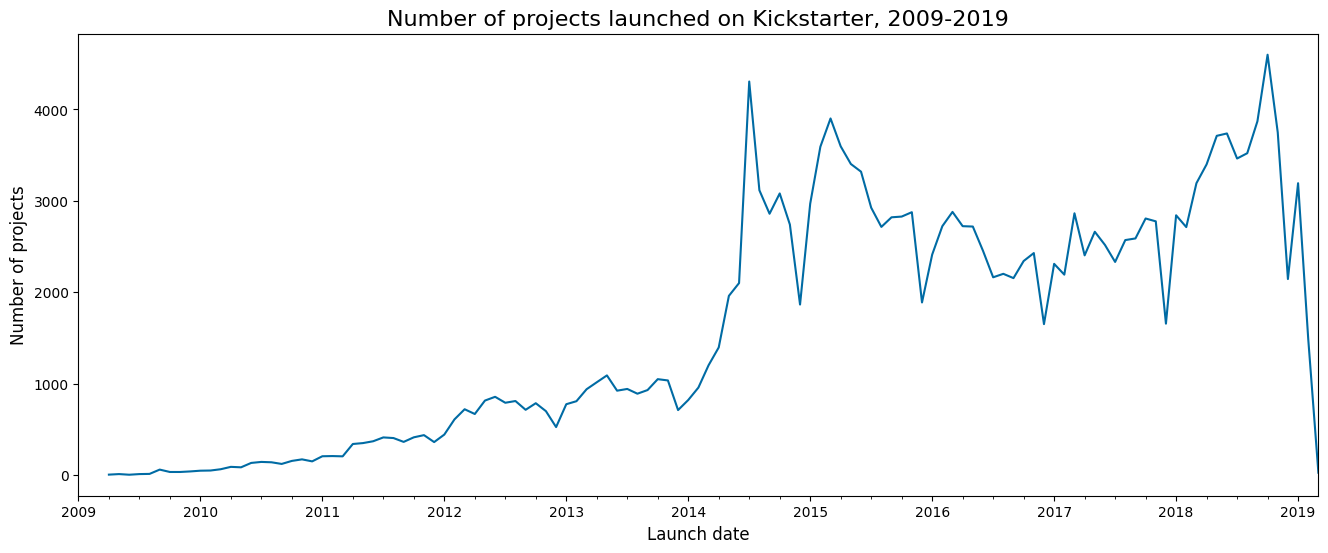

In [100]:
# Plotting the number of projects launched each month
plt.figure(figsize=(16,6))
df.set_index('launched_at').category.resample('MS').count().plot()
plt.xlim('2009-01-01', '2019-03-30') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Number of projects', fontsize=12)
plt.title('Number of projects launched on Kickstarter, 2009-2019', fontsize=16)
plt.show()


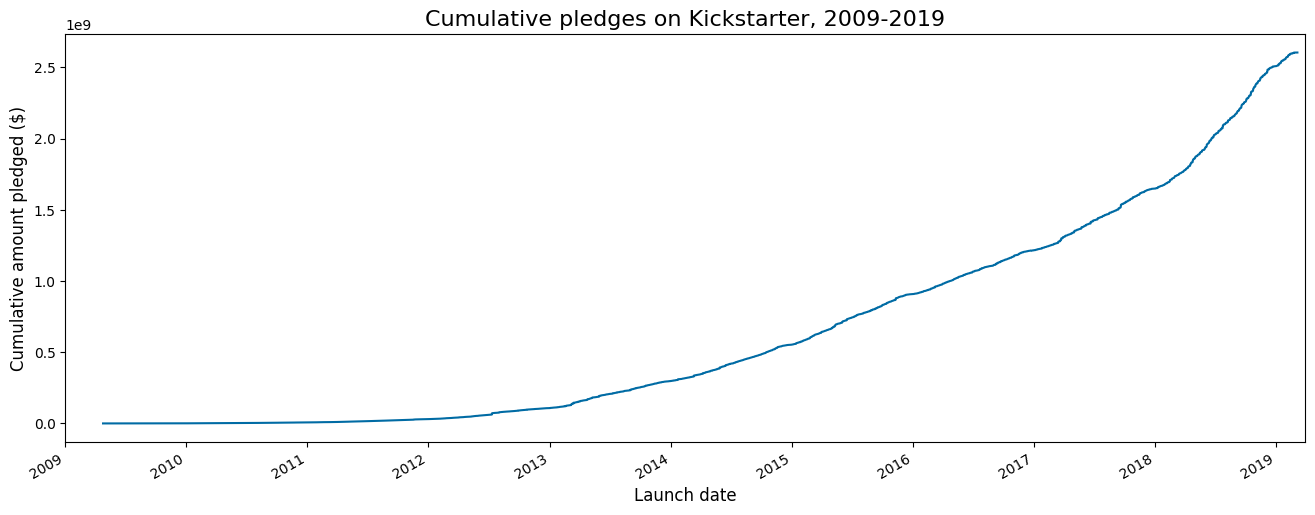

In [102]:
# Plotting the cumulative amount pledged on Kickstarter
plt.figure(figsize=(16,6))
df.set_index('launched_at').sort_index().usd_pledged.cumsum().plot()
plt.xlim('2009-01-01', '2019-03-30') # Limiting to whole months
plt.xlabel('Launch date', fontsize=12)
plt.ylabel('Cumulative amount pledged ($)', fontsize=12)
plt.title('Cumulative pledges on Kickstarter, 2009-2019', fontsize=16)
plt.show()

In [103]:
print("Average amount pledged per project in each year, in $:")
print(round(df.set_index('launched_at').usd_pledged.resample('YS').mean(),2))

Average amount pledged per project in each year, in $:
launched_at
2009-01-01     3675.72
2010-01-01     4720.86
2011-01-01     5668.03
2012-01-01     9154.24
2013-01-01    17126.45
2014-01-01     9644.24
2015-01-01     9627.66
2016-01-01    10685.02
2017-01-01    14593.17
2018-01-01    20999.88
2019-01-01    20279.06
Freq: AS-JAN, Name: usd_pledged, dtype: float64


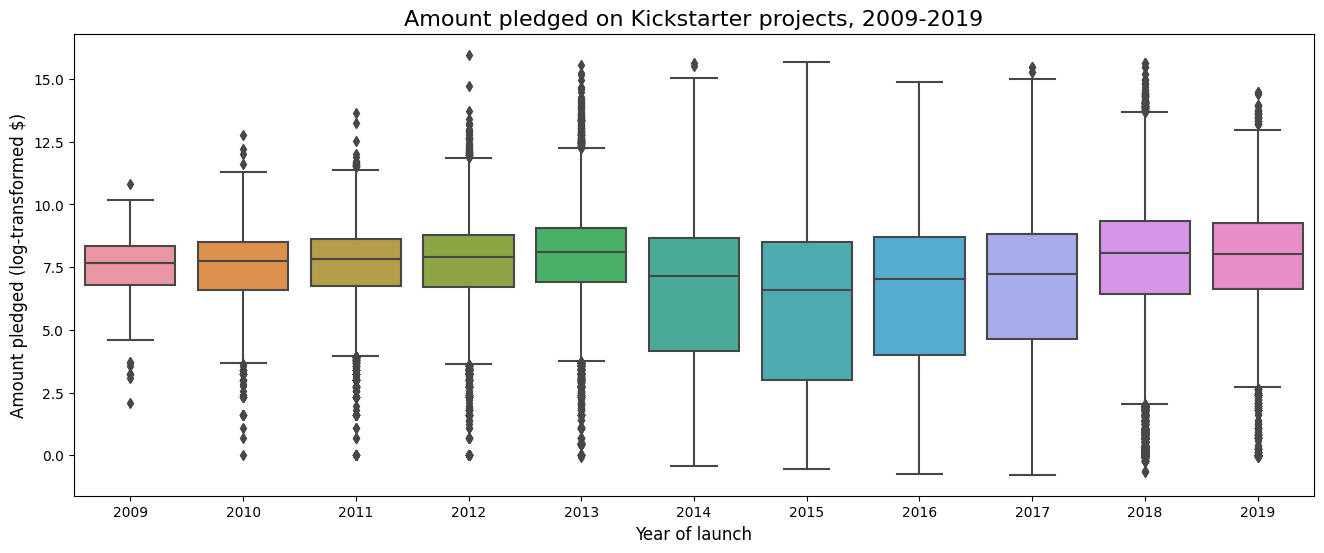

In [105]:
# Plotting the distribution of pledged amounts each year
plt.figure(figsize=(16,6))
sns.boxplot(df.launched_at.dt.year, np.log(df.usd_pledged))
plt.xlabel('Year of launch', fontsize=12)
plt.ylabel('Amount pledged (log-transformed $)', fontsize=12) # Log-transforming to make the trend clearer, as the distribution is heavily positively skewed
plt.title('Amount pledged on Kickstarter projects, 2009-2019', fontsize=16)
plt.show()

In [107]:
print("Average fundraising goal per project in each year, in $:")
print(round(df.set_index('launched_at').usd_goal.resample('YS').mean(),2))

Average fundraising goal per project in each year, in $:
launched_at
2009-01-01     3928.66
2010-01-01     5153.75
2011-01-01     6248.93
2012-01-01     9482.10
2013-01-01    14213.26
2014-01-01    39650.74
2015-01-01    65871.48
2016-01-01    50971.96
2017-01-01    45112.54
2018-01-01    16274.34
2019-01-01    12583.04
Freq: AS-JAN, Name: usd_goal, dtype: float64


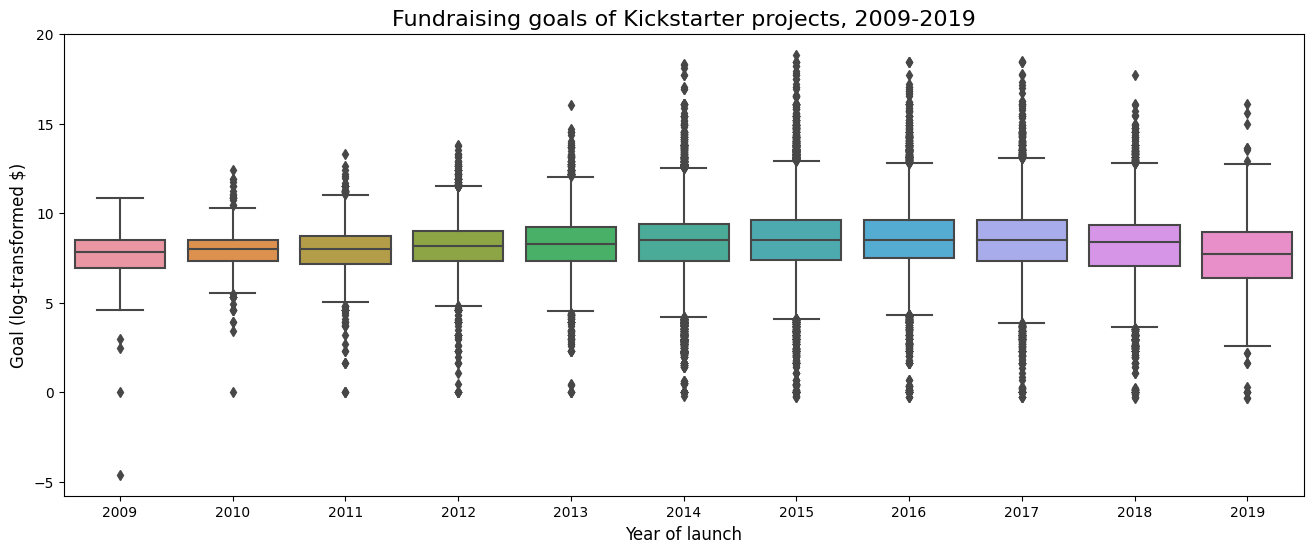

In [109]:
# Plotting the distribution of goal amounts each year
plt.figure(figsize=(16,6))
sns.boxplot(df.launched_at.dt.year, np.log(df.usd_goal))
plt.xlabel('Year of launch', fontsize=12)
plt.ylabel('Goal (log-transformed $)', fontsize=12) # Log-transforming to make the trend clearer, as the distribution is heavily positively skewed
plt.title('Fundraising goals of Kickstarter projects, 2009-2019', fontsize=16)
plt.show()

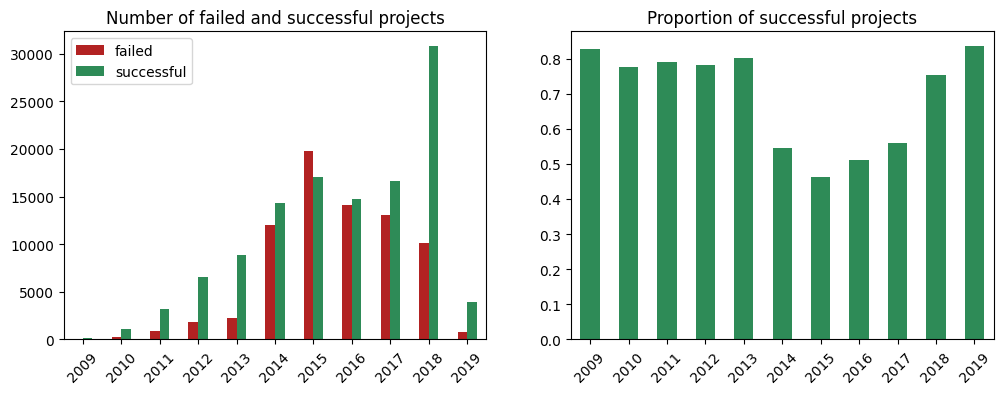

In [110]:
# Creating a dataframe grouped by year with columns for failed and successful
year_df = df.set_index('launched_at').state
year_df = pd.get_dummies(year_df).resample('YS').sum()

# Plotting the number and proportion of failed and successful projects each year
fig, ax = plt.subplots(1,2, figsize=(12,4))

year_df.plot.bar(ax=ax[0], color=['firebrick', 'seagreen'])
ax[0].set_title('Number of failed and successful projects')
ax[0].set_xlabel('')
ax[0].set_xticklabels(list(range(2009,2020)), rotation=45)

year_df.div(year_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax[1], color='seagreen') # Normalizes counts across rows
ax[1].set_title('Proportion of successful projects')
ax[1].set_xlabel('')
ax[1].set_xticklabels(list(range(2009,2020)), rotation=45)

plt.show()

---
### What types of projects do people launch and which are more successful?

* There are 15 project categories, of which music is the most common, followed by film & video and art.
* Technology projects have the highest goals by far (in terms of their median goal size), followed by food (e.g. funding for restaurants), with other categories generally much smaller in terms of their funding goals.
* However, technology projects are towards the bottom of the leaderboard in terms of the median amount actually pledged.
* Games, comics, dance and design projects obtain the greatest amount of funding, on average (median).
* The most frequently succesful categories are comics and dance (probably at least partly due to their relatively small funding goals), while the least successful are food, journalism and technology (again, probably because of their large funding goals).
* Comics and games tend to attract the most backers, but each backer tends to pledge less.
* Dance and film & video tend to attract the most generous backers.

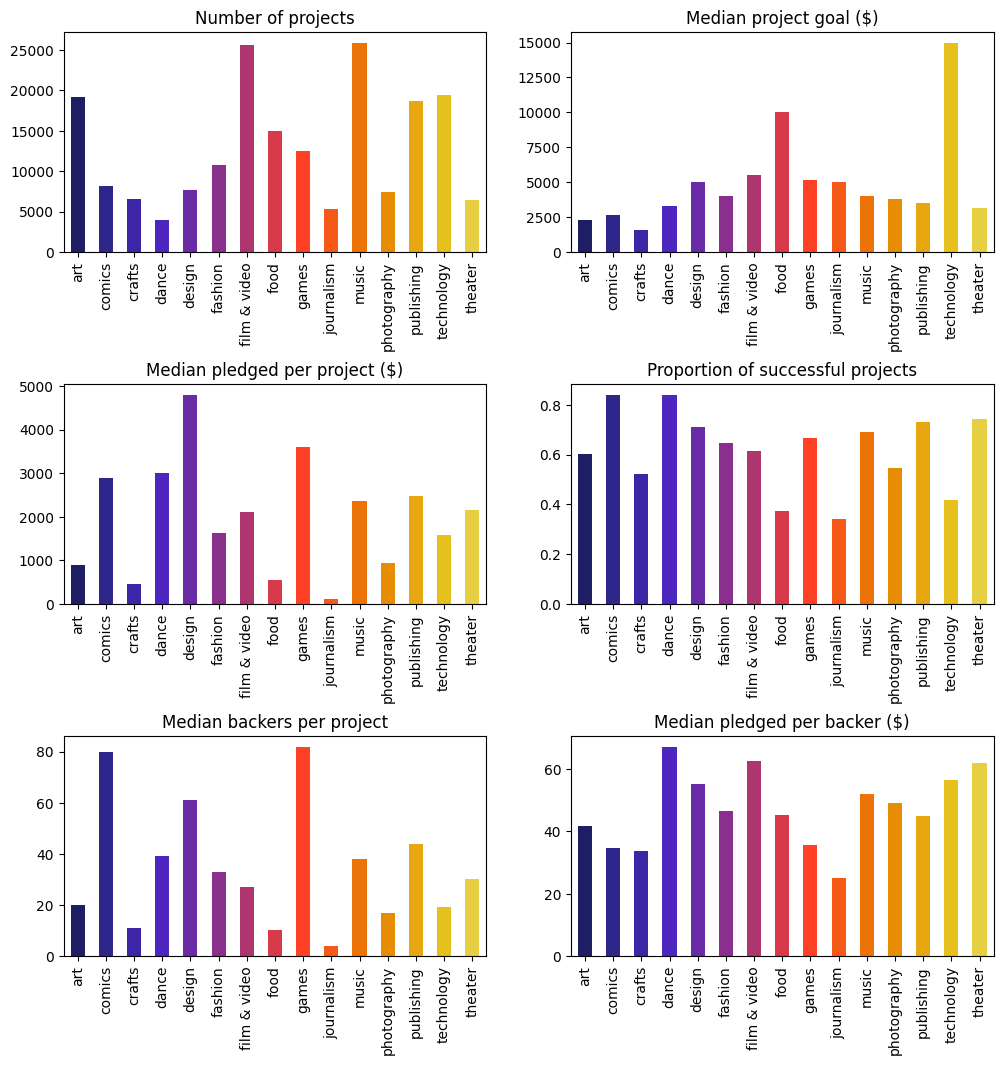

In [113]:
from matplotlib import cm

# Creating a dataframe grouped by category with columns for failed and successful
cat_df = pd.get_dummies(df.set_index('category').state).groupby('category').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.category.nunique())) # Setting a colormap


df.groupby('category').category.count().plot(kind='bar', ax=ax1, color=color)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('category').usd_goal.median().plot(kind='bar', ax=ax2, color=color)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('category').usd_pledged.median().plot(kind='bar', ax=ax3, color=color)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

cat_df.div(cat_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('category').backers_count.median().plot(kind='bar', ax=ax5, color=color)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('category').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.6)
plt.show()

---
### Where do project owners come from and are some countries more successful than others?

The vast majority of projects are from the US, with more than six times the total number of projects compared to the second most prolific country (the UK).
Switzerland has the highest median project goal size, although the differences in mean goal sizes are less extreme.
Projects from Hong Kong are the most successful, have the most backers, receive more per backer, and attract considerably more money than projects from elsewhere - nearly twice the next most lucrative country (Japan).

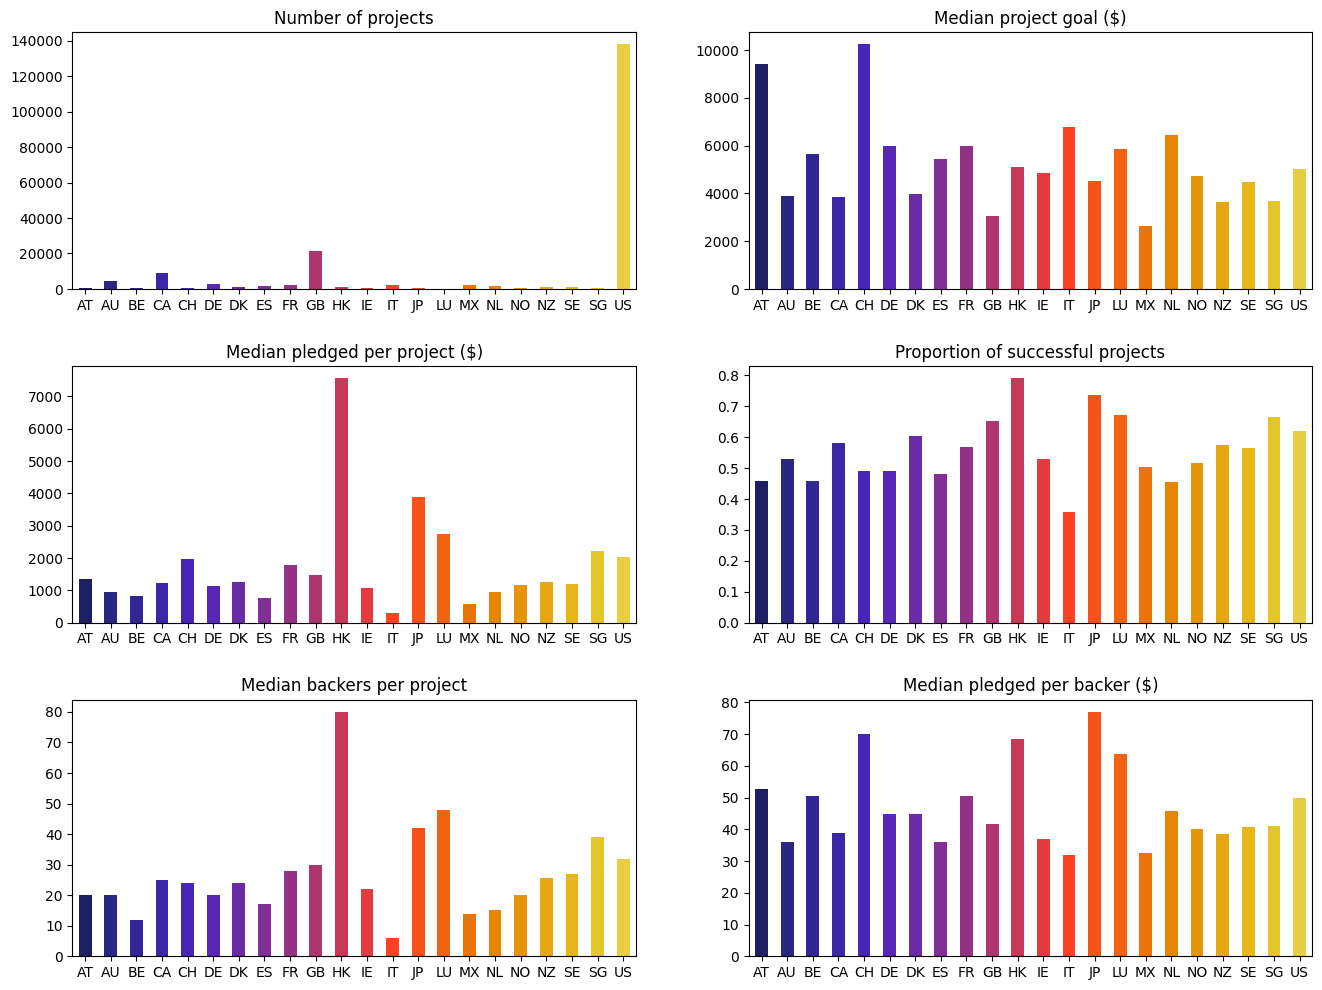

In [115]:
# Creating a dataframe grouped by country with columns for failed and successful
country_df = pd.get_dummies(df.set_index('country').state).groupby('country').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(16,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.country.nunique()))

df.groupby('country').country.count().plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects')
ax1.set_xlabel('')

df.groupby('country').usd_goal.median().plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('country').usd_pledged.median().plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

country_df.div(country_df.sum(axis=1), axis=0).successful.plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('country').backers_count.median().plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('country').pledge_per_backer.median().plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

---
### When is the best time to launch a project?

* Tuesday appears to be the best day to launch a project. It is the most popular launch day, and has the highest proportion of successful projects, the most backers, the highest median amount pledged per backer, and the highest median pledge amount overall.
* Weekends (and to a lesser extent Fridays) are the least popular days to launch a project, attract less money, have fewer backers, receive smaller pledges per backer, and are slightly less successful. They also tend to have lower goals, making it more surprising that they tend to be less successful and receive less funding.

In [117]:
#df_backup = df.copy()


31

In [118]:
#df["launch_day"] = df["launched_at"].dt.dayofweek

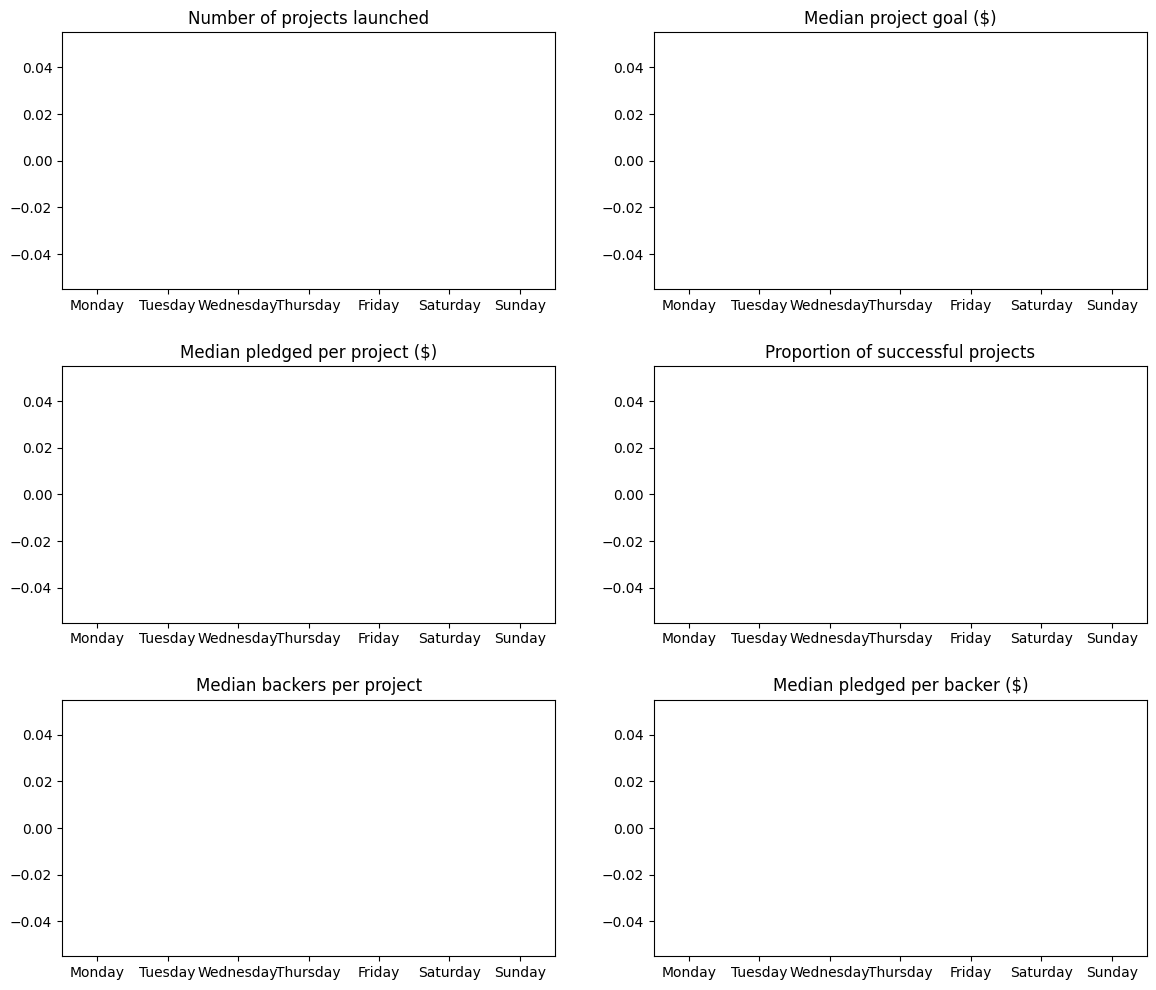

In [119]:
# Creating a dataframe grouped by the day on which they were launched, with columns for failed and successful
day_df = pd.get_dummies(df.set_index('launch_day').state).groupby('launch_day').sum()

# Plotting
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_day.nunique()))

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df.groupby('launch_day').launch_day.count().reindex(weekdays).plot(kind='bar', ax=ax1, color=color, rot=0)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')

df.groupby('launch_day').usd_goal.median().reindex(weekdays).plot(kind='bar', ax=ax2, color=color, rot=0)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')

df.groupby('launch_day').usd_pledged.median().reindex(weekdays).plot(kind='bar', ax=ax3, color=color, rot=0)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')

day_df.div(day_df.sum(axis=1), axis=0).successful.reindex(weekdays).plot(kind='bar', ax=ax4, color=color, rot=0) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')

df.groupby('launch_day').backers_count.median().reindex(weekdays).plot(kind='bar', ax=ax5, color=color, rot=0)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')

df.groupby('launch_day').pledge_per_backer.median().reindex(weekdays).plot(kind='bar', ax=ax6, color=color, rot=0)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')

fig.subplots_adjust(hspace=0.3)
plt.show()

---
### month 
The most popular month to launch a project is July, and the least common is December.
Interestingly, both months have the lowest success rates, lowest median pledge amounts, lowest median backers per project and lowest median amount pledged per backer.
Median goal sizes are roughly similar throughout most of the year, but smaller for projects launched in January.
The best month to launch in is October, which has the highest median amount pledged per project, the highest success rate and the highest number of backers per project.

In [123]:
# Creating a dataframe grouped by the month in which they were launched, with columns for failed and successful
month_df = pd.get_dummies(df.set_index('launch_month').state).groupby('launch_month').sum()

# Plotting
months = list(calendar.month_name)[1:]

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(14,12))

color = cm.CMRmap(np.linspace(0.1,0.8,df.launch_month.nunique()))

df.groupby('launch_month').launch_month.count().reindex(months).plot(kind='bar', ax=ax1, color=color, rot=45)
ax1.set_title('Number of projects launched')
ax1.set_xlabel('')
ax1.set_xticklabels(labels=ax1.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_goal.median().reindex(months).plot(kind='bar', ax=ax2, color=color, rot=45)
ax2.set_title('Median project goal ($)')
ax2.set_xlabel('')
ax2.set_xticklabels(labels=ax2.get_xticklabels(), ha='right')

df.groupby('launch_month').usd_pledged.median().reindex(months).plot(kind='bar', ax=ax3, color=color, rot=45)
ax3.set_title('Median pledged per project ($)')
ax3.set_xlabel('')
ax3.set_xticklabels(labels=ax3.get_xticklabels(), ha='right')

month_df.div(month_df.sum(axis=1), axis=0).successful.reindex(months).plot(kind='bar', ax=ax4, color=color, rot=45) # Normalizes counts across rows
ax4.set_title('Proportion of successful projects')
ax4.set_xlabel('')
ax4.set_xticklabels(labels=ax4.get_xticklabels(), ha='right')

df.groupby('launch_month').backers_count.median().reindex(months).plot(kind='bar', ax=ax5, color=color, rot=45)
ax5.set_title('Median backers per project')
ax5.set_xlabel('')
ax5.set_xticklabels(labels=ax5.get_xticklabels(), ha='right')

df.groupby('launch_month').pledge_per_backer.median().reindex(months).plot(kind='bar', ax=ax6, color=color, rot=45)
ax6.set_title('Median pledged per backer ($)')
ax6.set_xlabel('')
ax6.set_xticklabels(labels=ax6.get_xticklabels(), ha='right')

fig.subplots_adjust(hspace=0.4)
plt.show()

NameError: name 'calendar' is not defined

---
### Checking distributions

Most continuous numerical features other than blurb_length and campaign_days are heavily positively skewed. This is not an issue for some machine learning models, so these features will not be log-transformed for the first few models. After that, models will be ru-run using log-transformed data, to see whether this improves model accuracy.

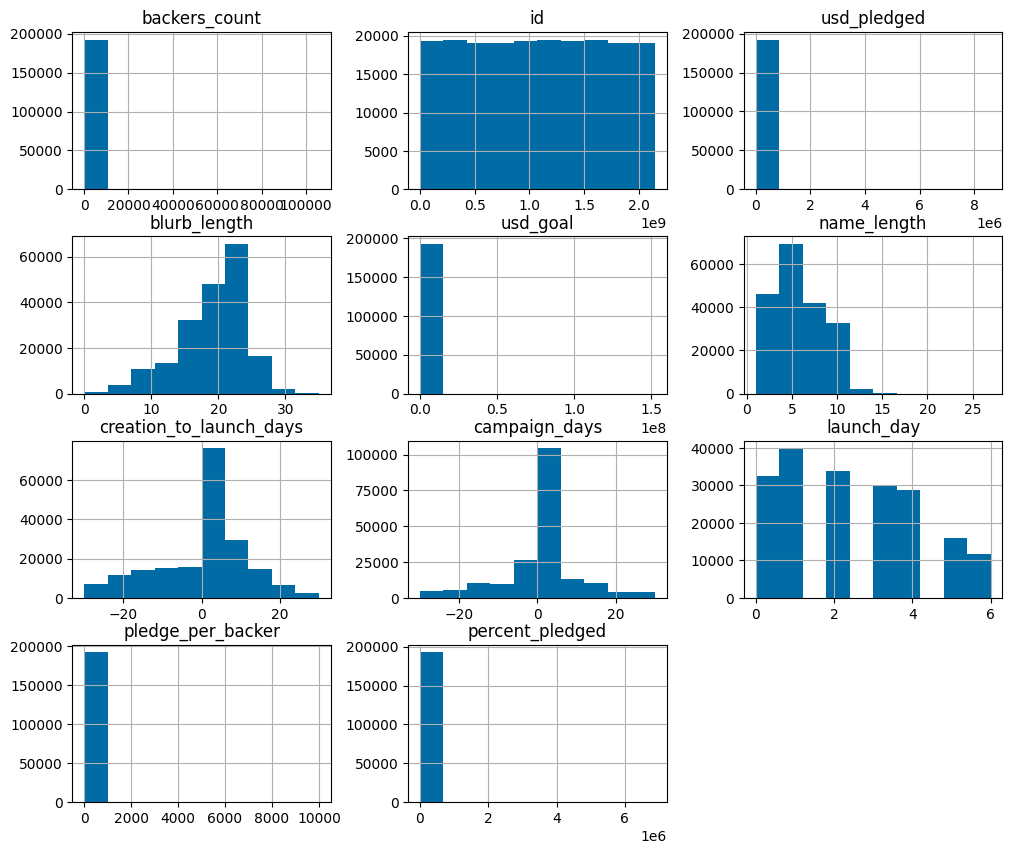

In [124]:
# Checking the distributions of continuous features
df[df.describe().columns].hist(figsize=(12,10));

# create pipelines

---
### Preparing the data for machine learning

Some features were retained for EDA purposes, but now need to be dropped in order to use machine learning models. This includes datetime features, features that are related to outcomes (e.g. the amount pledged and the number of backers) rather than related to the properties of the project itself (e.g. category, goal, length of campaign), categorical features which would result in too many one-hot encoded features (sub_category), and features that only have one category (is_starrable).

* Dropping columns and creating new dataframe
* df_transformed = df.drop(['backers_count', 'created_at', 'deadline', 'is_starrable', 'launched_at', 'usd_pledged', 'sub_category', 'pledge_per_backer'], axis=1)
* df_transformed.head()